# Load curvilinear model results from OPeNDAP

In [1]:
import xarray as xr


url = (
    "http://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/LOOFS/MODELS/201903/"
    "glofs.loofs.fields.forecast.20190320.t06z.nc"
)

ds = xr.open_dataset(url)
ds = ds.set_coords(names=['lon', 'lat'])

/home/filipe/miniconda3/envs/REGRID/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/filipe/miniconda3/envs/REGRID/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


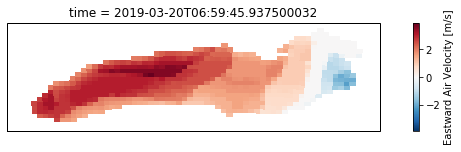

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


fig, ax = plt.subplots(
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(12, 2)
)

idx = 0
var = ds['air_u']

var[idx, ...].plot.pcolormesh(ax=ax, x='lon', y='lat');
ax.coastlines();

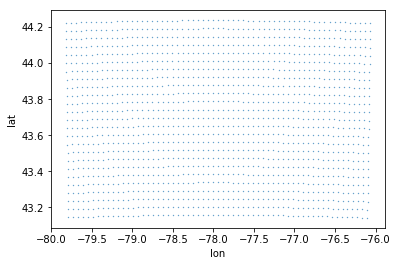

In [3]:
fig, ax = plt.subplots()
ax.scatter(ds['lon'], ds['lat'], s=0.1)
ax.set_xlabel('lon')
ax.set_ylabel('lat');

# re-grid to a rectilinear grid

In [4]:
import xesmf as xe
import numpy as np


lon = np.linspace(ds['lon'].min(), ds['lon'].max(), 40)
lat = np.linspace(ds['lat'].min(), ds['lat'].max(), 40)

ds_out = xr.Dataset(
    {
        'lat': (['lat'], lat),
        'lon': (['lon'], lon),
    }
)

regridder = xe.Regridder(var, ds_out, 'bilinear')
regridder

Overwrite existing file: bilinear_25x61_40x40.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_25x61_40x40.nc 
Reuse pre-computed weights? False 
Input grid shape:           (25, 61) 
Output grid shape:          (40, 40) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [5]:
new_var = regridder(var)

Check the interpolated values.

In [6]:
var.min(), var.max()

(<xarray.DataArray 'air_u' ()>
 array(-6.2, dtype=float32), <xarray.DataArray 'air_u' ()>
 array(7.58, dtype=float32))

In [7]:
new_var.min(), new_var.max()

(<xarray.DataArray 'air_u' ()>
 array(-6.193675), <xarray.DataArray 'air_u' ()>
 array(7.58))

In [8]:
vmin, vmax = var[idx, ...].min(), var[idx, ...].max()

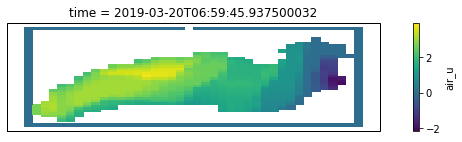

In [9]:
fig, ax = plt.subplots(
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(12, 2)
)

new_var[idx, ...].plot.pcolormesh(
    vmin=vmin, vmax=vmax,  # not sure how to get rid of that "frame" of zeroes.
    ax=ax, x='lon', y='lat'
)
ax.coastlines();

Not sure how to improve that interpolation yet. There are a few artifacts that are way out of the original values.

# Convert xarray dataset/dataarray to an iris cube

In [10]:
cube = new_var.to_iris()
cube

<iris 'Cube' of air_u / (unknown) (time: 60; lat: 40; lon: 40)>

# Save as grib with eccodes

I'm not a grib expert and I know there are a few variants out there. We need to test if this one is OK to be loaded in your workflow.

We need more metadata to be able to save as `grib`.
Not sure if the `coord_systems` is correct, I added something just to make it work.

In [11]:
import iris


x = cube.coord('lon')
y = cube.coord('lat')


x_coord = iris.coords.DimCoord(
    x.points,
    standard_name='longitude',
    var_name='lon',
    units='degrees_east',
)

y_coord = iris.coords.DimCoord(
    y.points,
    standard_name='latitude',
    var_name='lat',
    units='degrees_north'
)

Remove the coords with poor metadata and add the new ones.

In [12]:
cube.remove_coord('lat')
cube.remove_coord('lon')

cube.add_dim_coord(y_coord, 1)
cube.add_dim_coord(x_coord, 2)

coord_system = iris.coord_systems.GeogCS(654321)
                          
cube.coord(axis='Y').coord_system=coord_system
cube.coord(axis='X').coord_system=coord_system

# Round-trip test

In [13]:
iris.save(cube, 'rectlinear.grib', saver='GRIB2')

/home/filipe/miniconda3/envs/REGRID/lib/python3.7/site-packages/iris_grib/_save_rules.py:719: UserWarning: Unable to determine Grib2 parameter code for cube.
discipline, parameterCategory and parameterNumber have been set to "missing".
  warnings.warn('Unable to determine Grib2 parameter code for cube.\n'
/home/filipe/miniconda3/envs/REGRID/lib/python3.7/site-packages/iris_grib/_save_rules.py:1461: UserWarning: Unable to determine Grib2 parameter code for cube.
Message data may not be correctly scaled.
  warnings.warn('Unable to determine Grib2 parameter code for cube.\n'


In [14]:
cubes = iris.load_raw('rectlinear.grib')

In [15]:
cubes[0]

<iris 'Cube' of unknown / (unknown) (latitude: 40; longitude: 40)>

In [16]:
c = cubes[-1]
c

<iris 'Cube' of unknown / (unknown) (latitude: 40; longitude: 40)>

In [17]:
len(cubes)

60

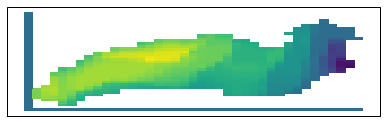

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


fig, ax = plt.subplots(
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(12, 2)
)


c = cubes[idx]  # grib has one cube per time!
ax.pcolormesh(
    c.coord(axis='x').points,
    c.coord(axis='y').points,
    c.data,
    vmin=vmin, vmax=vmax,
)
ax.coastlines();